In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
from pyclustertend import hopkins
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Purpose of this file is to perform further EDA using our principal components, to observe whether any patterns or structure exists within our data

In [114]:
df = pd.read_csv("./Data/PCAData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     397 non-null    float64
 1   PC2     397 non-null    float64
 2   PC3     397 non-null    float64
 3   PC4     397 non-null    float64
 4   PC5     397 non-null    float64
 5   Player  397 non-null    object 
 6   Team    397 non-null    object 
dtypes: float64(5), object(2)
memory usage: 21.8+ KB


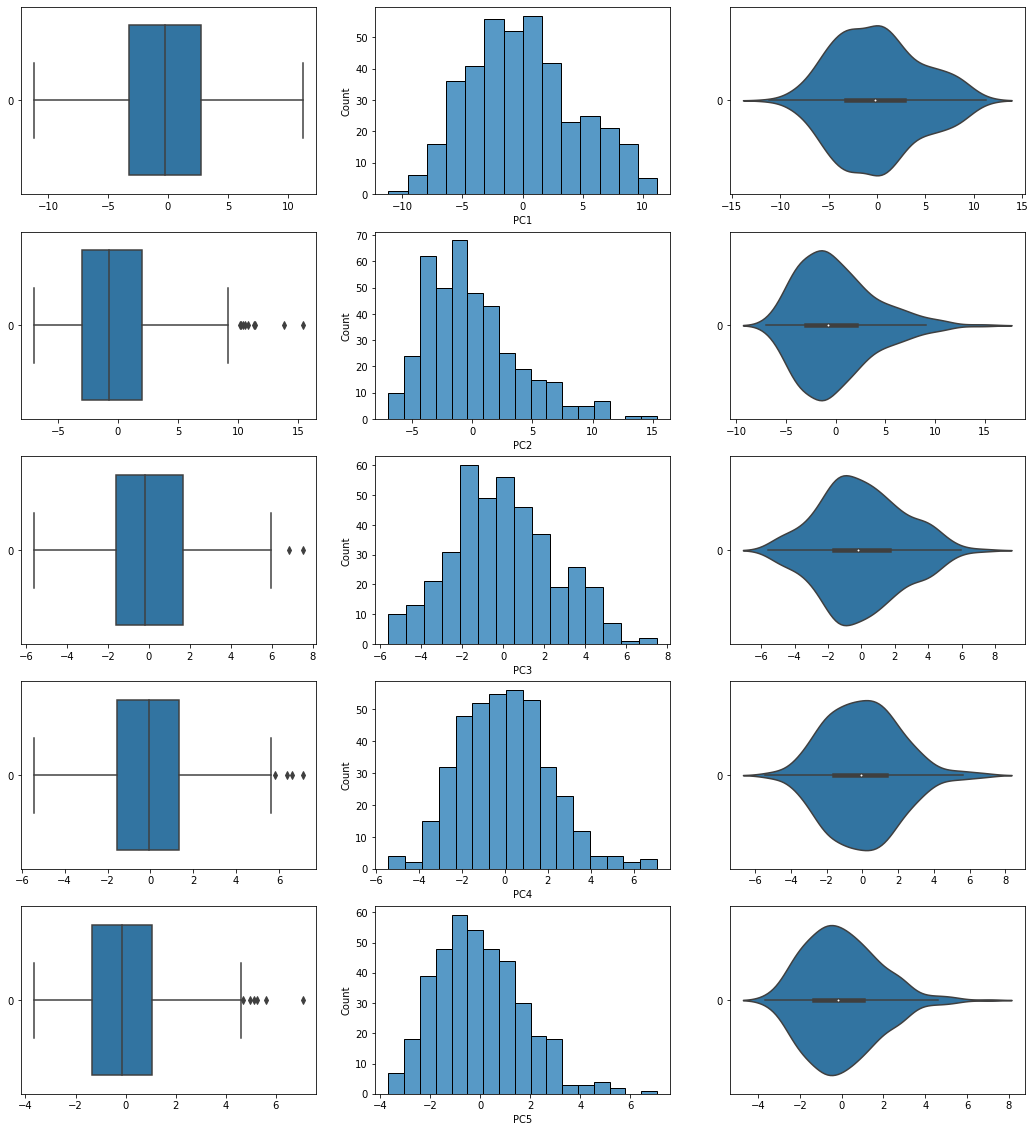

In [115]:
# Draw the distributions of all variables
f, axes = plt.subplots(5, 3, figsize=(18, 20))

for i in range (1, 6):
    sns.boxplot(data = df[f"PC{i}"], orient = "h", ax = axes[i - 1, 0])
    sns.histplot(data = df[f"PC{i}"], ax = axes[i - 1, 1])
    sns.violinplot(data = df[f"PC{i}"], orient = "h", ax = axes[i - 1, 2])

## Insight
We notice most principal components (pcs) have a roughly even distribtution, with some PCs being left skewed. These are interestingly the same PCs that appear to have a greater number of anomalies

In [116]:
# find number of anomalalies for each column
q1 = df.quantile(0.25)
q2 = df.quantile(0.75)
((df < (q1 - 1.5 * (q2 - q1))) | (df > (q2 + 1.5 * (q2 - q1)))).sum()


/var/folders/vn/ptt2zv55465dbp8fs33z2cqw0000gn/T/ipykernel_1093/2059429225.py:4: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



PC1       0
PC2       9
PC3       2
PC4       4
PC5       6
Player    0
Team      0
dtype: int64

Given our data has almost 400 players the small percentage of anomalies is not a real concern

In order to get a sense of whether our data has clustering tendencies we first attempt a visualisation approach

In [117]:
# comparing our most significant PCS
fig1 = go.Scatter(x=df['PC1'],
                  y=df['PC2'],
                  mode='markers')

mylayout = go.Layout(xaxis=dict(title="PC1"),
                     yaxis=dict( title="PC2"))

fig = go.Figure(
    data=[fig1],
    layout=mylayout,
)
fig.show()

Our top 2 pcs combined do not show any obvious clusters. We continue adding more features

In [118]:
fig1 = go.Scatter3d(x=df['PC1'],
                    y=df['PC2'],
                    z=df['PC3'],
                    marker=dict(opacity=0.9,
                                reversescale=True,
                                colorscale='Blues',
                                size=5),
                    line=dict (width=0.02),
                    mode='markers')

#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="PC1"),
                                yaxis=dict( title="PC2"),
                                zaxis=dict(title="PC3")),)

fig = go.Figure(
    data=[fig1],
    layout=mylayout,
)
fig.show()

Having run out of spatial dimensions, we use color to represent the 4th pc

In [119]:
markercolor = df['PC4']

fig1 = go.Scatter3d(x=df['PC1'],
                    y=df['PC2'],
                    z=df['PC3'],
                    marker=dict(color=markercolor,
                                opacity=1,
                                reversescale=True,
                                colorscale='Blues',
                                size=5),
                    line=dict (width=0.02),
                    mode='markers')

mylayout = go.Layout(scene=dict(xaxis=dict( title="PC1"),
                                yaxis=dict( title="PC2"),
                                zaxis=dict(title="PC3")),)

fig = go.Figure(
    data=[fig1],
    layout=mylayout,
)
fig.show()

For the 5th Principle Component we intend to use size. However to do this we must first linearly shift all values to be greater than zero. Although some information is lost in this process, we carry on to see if there are any interesting observations that could be made.

In [120]:
tempPc5 = df['PC5'] + abs(df["PC5"].min()) + 1

markercolor = df['PC4']
markersize = tempPc5*1.5

fig1 = go.Scatter3d(x=df['PC1'],
                    y=df['PC2'],
                    z=df['PC3'],
                    marker=dict(size=markersize,
                                color=markercolor,
                                opacity=1,
                                reversescale=True,
                                colorscale='Blues',
                                ),
                    line=dict (width=0.02),
                    mode='markers')

mylayout = go.Layout(scene=dict(xaxis=dict( title="PC1"),
                                yaxis=dict( title="PC2"),
                                zaxis=dict(title="PC3")),)

fig = go.Figure(
    data=[fig1],
    layout=mylayout,
)
fig.show()

Although we may at this point attempt to draw circles in our data and try to identify groups it seems still rather difficult to do so visually. As such we use hopkins statistic to check whether our data truly has any intrinsic clustering tendency

In [121]:
# conducting hopkins test
tempDf = df.drop(['Player','Team'],axis=1)
scaler = StandardScaler()
scaledDf = scaler.fit_transform(tempDf)
scaledDf = pd.DataFrame(scaledDf, columns = ['PC1','PC2','PC3','PC4','PC5'])

hopkins(scaledDf, df.shape[0])

0.29100791009562305

## Insight
Our hopkins statistic has a value of about 0.3. A statistic value of 1 would have indicated randomly distributed data while a statistic of 0 would indicate a high probability of the presence of clusters. We find a value of 0.3 sufficient to conclude that our data does in fact have natural clusters

An initial guess might be that players who are further away in a particular PC would fall under a different cluster, especially so for pcs 1 and 2, as they seem to be more significant in our data. For example a player who has a high in PC1 should not ideally be grouped with a player who has a high negative value. Hence we explore such differences below by comparing the top 10 players (high positives) of each pc with the bottom 10 (high negatives)

In [122]:
# PC 1 high positives
df.nlargest(10, "PC1")

,PC1,PC2,PC3,PC4,PC5,Player,Team
94,11.205446,6.594646,2.070441,0.732936,-2.851871,Rudy Gobert,UTA
82,11.143029,5.505923,3.158834,0.717988,-2.108717,Clint Capela,ATL
232,9.922686,2.147343,1.244189,-3.788807,1.378683,Hassan Whiteside,SAC
219,9.825733,2.422078,1.410772,-5.432866,-1.368253,Moses Brown,BOS
274,9.818563,0.717860,2.212906,-2.940581,-1.943885,Daniel Gafford,WAS
122,9.292007,4.933967,0.634086,0.489422,-0.064595,Jarrett Allen,CLE
86,9.286821,7.472394,4.321400,0.847492,0.853605,Andre Drummond,LAL
369,9.137940,-1.076732,3.095404,-5.086068,-0.332779,Onyeka Okongwu,ATL
91,9.068008,6.314492,-0.186258,2.134439,1.504472,Deandre Ayton,PHX
258,9.036206,1.693026,4.168636,-2.381979,-0.778149,DeAndre Jordan,BKN


In [123]:
# PC 1 high negatives
df.nsmallest(10, "PC1")

,PC1,PC2,PC3,PC4,PC5,Player,Team
14,-11.163901,7.078145,4.064762,-3.664806,-0.949346,Trae Young,ATL
70,-9.363684,5.871891,3.661444,0.908717,2.798693,Chris Paul,PHX
2,-9.050960,7.846904,-0.803615,-4.675235,0.191907,Damian Lillard,POR
20,-8.743244,10.151195,4.311223,-1.424197,0.242651,James Harden,BKN
15,-8.351620,5.938560,2.692065,-3.517273,-2.537802,De'Aaron Fox,SAC
45,-8.150752,3.692981,1.311568,2.405961,-2.975265,Fred VanVleet,TOR
72,-8.052750,3.117919,1.382025,1.444848,-1.051521,Mike Conley,UTA
0,-7.937506,6.538865,-3.463275,-2.545460,-2.152836,Stephen Curry,GSW
24,-7.875860,7.261780,2.955300,-4.726352,-1.045268,Shai Gilgeous-Alexander,OKC
11,-7.766172,6.083182,-0.152628,-2.334082,-0.384307,Donovan Mitchell,UTA


### Brief Analysis
From the comparison, we can see that PC1 favours players that are known to rebound a lot and their position in the game would be center. 
On the other hand, PC1 does not seem to favour guards especially those smaller in size that do not snag as many rebounds.

In [124]:
# PC 2 high positives
df.nlargest(10, "PC2")

,PC1,PC2,PC3,PC4,PC5,Player,Team
3,6.485586,15.372255,-4.301402,1.813892,7.064400,Joel Embiid,PHI
12,2.910167,13.862939,-0.168364,6.347329,4.959652,Nikola Jokic,DEN
4,0.268335,11.387311,1.997607,-1.461920,0.566734,Giannis Antetokounmpo,MIL
5,-6.885186,11.322543,2.468263,-4.001972,0.975713,Luka Doncic,DAL
18,4.471727,10.804592,-3.564533,2.544699,3.068546,Karl-Anthony Towns,MIN
40,4.480679,10.591510,0.792217,5.631779,1.056396,Domantas Sabonis,IND
29,-6.522524,10.381904,5.648336,1.162799,0.352905,Russell Westbrook,WAS
22,-2.023788,10.246483,-1.289384,3.110333,1.398120,Julius Randle,NYK
20,-8.743244,10.151195,4.311223,-1.424197,0.242651,James Harden,BKN
32,-3.312234,9.143393,4.109317,0.879535,-0.744779,Jimmy Butler,MIA


In [125]:
# PC 2 high negatives
df.nsmallest(10, "PC2")

,PC1,PC2,PC3,PC4,PC5,Player,Team
394,1.295650,-6.978208,1.753030,0.083624,0.821960,KZ Okpala,MIA
395,1.700019,-6.561837,1.388867,-1.807182,-1.021137,Wes Iwundu,NOP
319,0.721943,-6.455947,-4.119172,-1.642261,0.889667,Mychal Mulder,GSW
372,-0.120502,-6.454913,0.709009,-1.348027,0.079093,Charlie Brown Jr.,OKC
391,0.721713,-6.328150,1.133161,2.432960,1.272474,Gary Clark,PHI
259,-3.721771,-6.260489,-1.310827,-0.278266,1.732919,JJ Redick,DAL
312,-0.346875,-5.840594,-2.931037,-1.689617,2.457950,Max Strus,MIA
385,-2.957620,-5.699573,4.081078,-1.835484,5.605563,Jordan Bone,ORL
326,-0.755227,-5.691934,-4.318470,-1.896146,-0.393124,Garrison Mathews,WAS
332,-3.154190,-5.666523,0.050049,2.227031,2.227490,Tyler Johnson,BKN


### Brief Analysis

From the comparison, we can  see that PC2 favours players that are known to be All-Star Caliber and contribute heavily to their team. On the other hand, PC2 does not facour players that are bit-part.

In [126]:
# PC 3 high positives
df.nlargest(10, "PC3")

,PC1,PC2,PC3,PC4,PC5,Player,Team
396,5.541327,-2.024050,7.495931,-0.558761,0.557076,Ed Davis,MIN
218,-6.257650,0.243264,6.854208,3.011326,-1.380436,T.J. McConnell,IND
393,-3.973016,-4.334199,5.979366,1.584614,4.677171,Matthew Dellavedova,CLE
29,-6.522524,10.381904,5.648336,1.162799,0.352905,Russell Westbrook,WAS
171,6.650793,4.921198,5.474863,2.452984,-0.872742,Mason Plumlee,DET
333,-5.067874,-1.727588,5.226589,1.698896,3.180500,Rajon Rondo,LAC
353,7.079060,-1.422005,5.177493,0.292415,-2.376384,Bismack Biyombo,CHA
227,8.312593,0.216278,5.068474,1.903971,-3.521997,Mitchell Robinson,NYK
286,-5.802896,-1.514388,4.978201,1.638269,-0.328502,Killian Hayes,DET
253,6.983447,2.068292,4.915606,0.471541,-1.268736,Steven Adams,NOP


In [127]:
# PC 3 high negatives
df.nsmallest(10, "PC3")

,PC1,PC2,PC3,PC4,PC5,Player,Team
51,2.512376,2.003337,-5.600976,0.264345,-0.484766,Michael Porter Jr.,DEN
99,-1.623510,-1.320074,-5.315098,2.291713,-2.460954,Joe Harris,BKN
67,-1.424777,0.614858,-5.305410,-2.421735,0.004655,Tim Hardaway Jr.,DAL
46,-2.258860,0.374138,-5.069906,-1.117856,-1.968412,Malik Beasley,MIN
143,-1.203998,-3.850243,-5.036304,1.847482,-1.211689,Davis Bertans,WAS
114,1.361587,2.170334,-5.002336,-1.683924,2.885995,Danilo Gallinari,ATL
115,-3.351702,-2.451920,-4.965225,3.912939,-2.410322,Duncan Robinson,MIA
111,0.537003,0.739712,-4.925615,0.379836,2.458314,Marcus Morris Sr.,LAC
66,-1.871537,2.348158,-4.811244,-0.790497,-0.868800,Bojan Bogdanovic,UTA
105,1.384499,-1.305843,-4.795708,-2.423131,-1.869776,Doug McDermott,IND


### Brief Analysis

From the comparison, we can see that PC3 favours players that are known to be poor shooters of the ball (points scored from jumpers). On the other hand, it does not favour those that shoot the ball well

In [128]:
# PC 4 high positives
df.nlargest(10, "PC4")

,PC1,PC2,PC3,PC4,PC5,Player,Team
272,-0.820468,4.110968,4.811421,7.094368,-1.578901,Draymond Green,GSW
276,-1.239998,-1.348811,-0.001691,6.586149,-2.589129,Royce O'Neale,UTA
12,2.910167,13.862939,-0.168364,6.347329,4.959652,Nikola Jokic,DEN
25,2.485577,8.809016,-4.362541,5.805483,5.137527,Nikola Vucevic,CHI
40,4.480679,10.591510,0.792217,5.631779,1.056396,Domantas Sabonis,IND
195,1.953889,1.586052,1.427798,5.440084,-0.805503,Larry Nance Jr.,CLE
351,2.756174,-1.091183,1.258818,5.192533,1.748267,Marc Gasol,LAL
375,-1.121647,-3.765217,2.601852,5.039105,0.384952,Andre Iguodala,MIA
234,0.146639,-1.955563,-1.112744,4.774976,0.212080,Nicolas Batum,LAC
222,0.741206,-0.350927,-1.625344,4.540834,-2.238878,Robert Covington,POR


In [129]:
# PC 4 high negatives
df.nsmallest(10, "PC4")

,PC1,PC2,PC3,PC4,PC5,Player,Team
219,9.825733,2.422078,1.410772,-5.432866,-1.368253,Moses Brown,BOS
369,9.137940,-1.076732,3.095404,-5.086068,-0.332779,Onyeka Okongwu,ATL
24,-7.875860,7.261780,2.955300,-4.726352,-1.045268,Shai Gilgeous-Alexander,OKC
2,-9.050960,7.846904,-0.803615,-4.675235,0.191907,Damian Lillard,POR
1,-4.254931,7.347971,-2.386292,-4.267921,-2.230382,Bradley Beal,WAS
5,-6.885186,11.322543,2.468263,-4.001972,0.975713,Luka Doncic,DAL
232,9.922686,2.147343,1.244189,-3.788807,1.378683,Hassan Whiteside,SAC
14,-11.163901,7.078145,4.064762,-3.664806,-0.949346,Trae Young,ATL
161,-1.733764,-0.581181,-0.624454,-3.661400,-0.541838,Dwayne Bacon,ORL
31,-6.109753,6.702839,2.325239,-3.654931,0.949762,DeMar DeRozan,SAS


### Brief Analysis

From the comparison, PC4 tends to favour players that are forwards/centers that are playmakers from the paint. On the other hand, they tend to not favour players that are not playmakers in the paint. 

In [130]:
# PC 5 high positives
df.nlargest(10, "PC5")

,PC1,PC2,PC3,PC4,PC5,Player,Team
3,6.485586,15.372255,-4.301402,1.813892,7.064400,Joel Embiid,PHI
385,-2.957620,-5.699573,4.081078,-1.835484,5.605563,Jordan Bone,ORL
321,-7.732204,-4.549573,4.028187,1.265807,5.263079,Yogi Ferrell,LAC
25,2.485577,8.809016,-4.362541,5.805483,5.137527,Nikola Vucevic,CHI
12,2.910167,13.862939,-0.168364,6.347329,4.959652,Nikola Jokic,DEN
393,-3.973016,-4.334199,5.979366,1.584614,4.677171,Matthew Dellavedova,CLE
106,3.391149,2.793597,-4.438877,1.308110,4.587822,LaMarcus Aldridge,BKN
112,-0.162973,1.713159,-3.950777,-2.619541,4.420993,Carmelo Anthony,POR
30,4.860608,9.065220,-1.193427,2.688710,4.107700,Anthony Davis,LAL
247,-6.258242,-0.906818,4.413085,-1.427961,3.995718,Mike James,BKN


In [131]:
# PC 5 high negatives
df.nsmallest(10, "PC5")

,PC1,PC2,PC3,PC4,PC5,Player,Team
350,7.756487,1.145011,4.295703,0.660685,-3.657095,Nerlens Noel,NYK
334,4.755452,-1.767571,3.842910,1.319521,-3.556963,Jarred Vanderbilt,MIN
227,8.312593,0.216278,5.068474,1.903971,-3.521997,Mitchell Robinson,NYK
78,2.071969,0.946999,-2.782055,-0.959971,-3.162554,Kelly Oubre Jr.,GSW
254,-0.072332,-3.243070,-1.332328,-1.809486,-3.152910,Edmond Sumner,IND
128,6.325235,3.102599,-3.336557,1.144631,-3.072485,Myles Turner,IND
21,-4.865603,5.547620,-0.722282,-3.243500,-3.069674,Collin Sexton,CLE
45,-8.150752,3.692981,1.311568,2.405961,-2.975265,Fred VanVleet,TOR
94,11.205446,6.594646,2.070441,0.732936,-2.851871,Rudy Gobert,UTA
6,-5.269893,6.243382,-2.256425,-3.296975,-2.800266,Zach LaVine,CHI


### In conclusion:

From the comparison and prior basketball knowledge, PC5 is the most interesting PC cluster. The reason is that the players are not known to be associated with each other and they are registered as different positions on the roster

The above analysis however, ignores any potential relationships between PCs and how they might interact with one another to form clusters. We do a simple *bi-variate analysis*, in this regard.

# Bi-Variate Exploration

<AxesSubplot:>

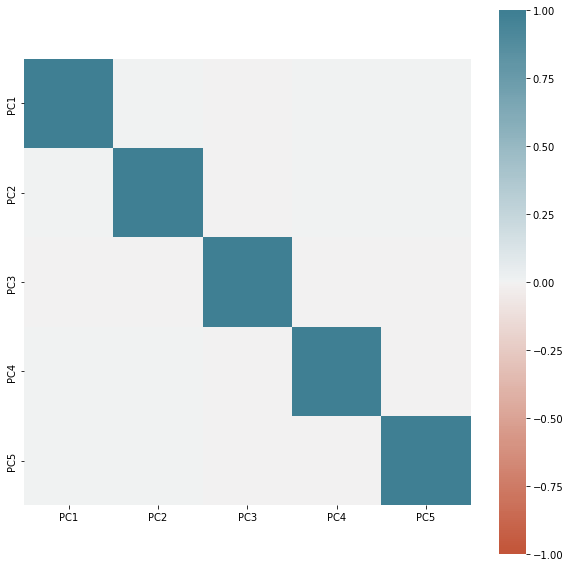

In [132]:
# correlation heatmap
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(),
            vmin = -1, vmax = 1, center = 0,
            cmap = sns.diverging_palette(20, 220, n = 500),
            square = True)

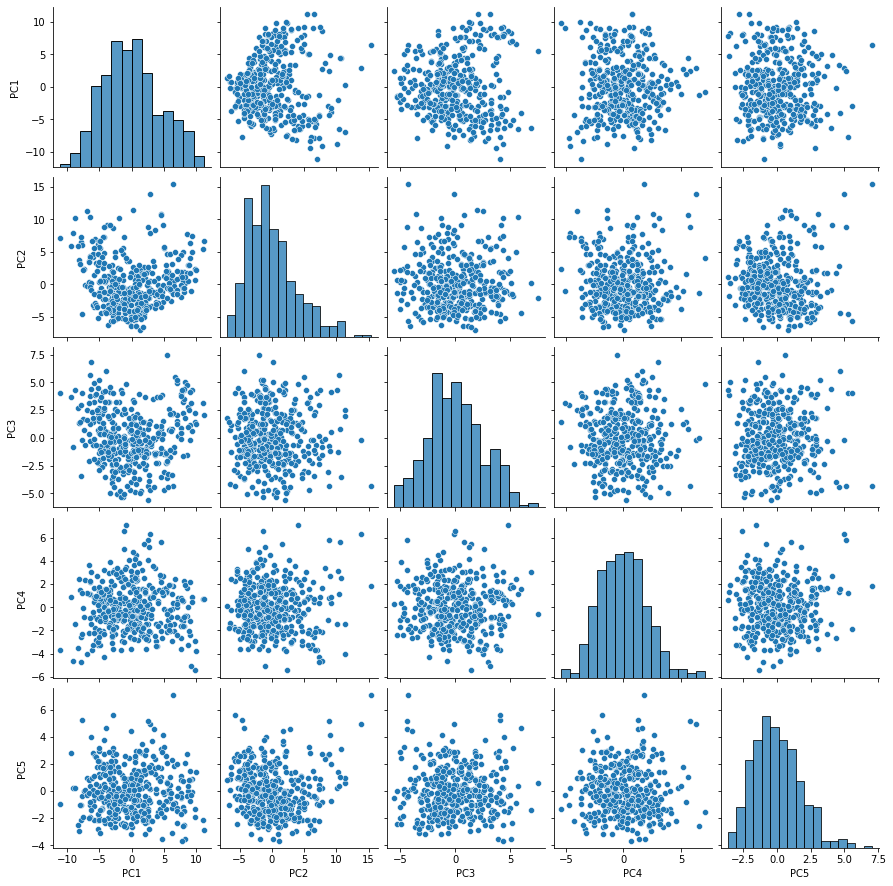

In [133]:
# pairplot
sns.pairplot(data=df)

As one would expect all the principal components are orthogonal and hence uncorrelated with one another. So how then could we consider multiple PCs when trying to understand how our data might be clustered?